In [1]:
# pip install numpy --upgrade

In [2]:
pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 8.1 MB/s 
     |████████████████████████████████| 511.7 MB 6.0 kB/s 
     |████████████████████████████████| 438 kB 68.5 MB/s 
     |████████████████████████████████| 1.6 MB 51.3 MB/s 
     |████████████████████████████████| 5.8 MB 56.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninst

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("train.csv")
df.head(5)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0.0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0.0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0.0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0.0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0.0


In [6]:
df.groupby('target').describe()

qid                                     question_text           \
          count   unique                   top freq         count   unique   
target                                                                       
0.0     1096613  1096613  00002165364db923c7e6    1       1096613  1096613   
1.0       72321    72321  0000e91571b60c2fb487    1         72321    72321   

                                                                
                                                      top freq  
target                                                          
0.0     How did Quebec nationalists see their province...    1  
1.0     Has the United States become the largest dicta...    1

In [7]:
df['target'].value_counts()

0.0    1096613
1.0      72321
Name: target, dtype: int64

In [8]:
80810/1225312

0.06595054973753624

6% insincere ques, 94% sincere ques: This indicates class imbalance

In [9]:
df_spam = df[df['target']==1]
df_spam.shape

(72321, 3)

In [10]:
df_ham = df[df['target']==0]
df_ham.shape

(1096613, 3)

In [11]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(72321, 3)

In [12]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(144642, 3)

In [13]:
df_balanced['target'].value_counts()

0.0    72321
1.0    72321
Name: target, dtype: int64

In [14]:
df_balanced_1=df_balanced

In [15]:
df_balanced_1.drop("qid",axis=1, inplace=True)

In [16]:
df_balanced_1.shape

(144642, 2)

In [17]:
df_balanced_copy= df_balanced

In [18]:
df_balanced = df_balanced_1

In [19]:
df_balanced['target'].value_counts()

0.0    72321
1.0    72321
Name: target, dtype: int64

In [20]:
df_balanced.head()

,question_text,target
665069,How do you tell the effectiveness of skin care...,0.0
539199,What are some complications during pregnancy?,0.0
808117,"What is the fastest way to make over $100,000 ...",0.0
857712,Why I am not receiving calls for job in India ...,0.0
1029829,How can you solve the limitation of DSP 28335?,0.0


In [21]:
df_balanced[df_balanced['target']==1].head()

,question_text,target
22,Has the United States become the largest dicta...,1.0
30,Which babies are more sweeter to their parents...,1.0
110,If blacks support school choice and mandatory ...,1.0
114,I am gay boy and I love my cousin (boy). He is...,1.0
115,Which races have the smallest penis?,1.0


#### Split it into training and test data set

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['question_text'],df_balanced['target'], stratify=df_balanced['target'])

In [23]:
X_train.head(4)

1085352             Why do student loans require a cosigner?
516056     Don’t you think every Indian should unite agai...
663971     What are some Swedish universities which offer...
314812           Why Indian men creep all women on Facebook?
Name: question_text, dtype: object

#### Now lets import BERT model and get embeding vectors for few sample statements

In [24]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

#### Build Model
There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

So far we have built sequential model. But below we will build functional model. 

In [25]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [27]:
len(X_train)

108481

In [28]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

#### Train the model

In [29]:
model.fit(X_train, y_train, epochs=6)

Epoch 1/6
3391/3391 [==============================] - 1130s 330ms/step - loss: 0.4743 - accuracy: 0.7809 - precision: 0.7887 - recall: 0.7674
Epoch 2/6
3391/3391 [==============================] - 1119s 330ms/step - loss: 0.4085 - accuracy: 0.8207 - precision: 0.8228 - recall: 0.8174
Epoch 3/6
3391/3391 [==============================] - 1116s 329ms/step - loss: 0.4000 - accuracy: 0.8256 - precision: 0.8273 - recall: 0.8229
Epoch 4/6
3391/3391 [==============================] - 1113s 328ms/step - loss: 0.3958 - accuracy: 0.8279 - precision: 0.8290 - recall: 0.8262
Epoch 5/6
3391/3391 [==============================] - 1117s 329ms/step - loss: 0.3943 - accuracy: 0.8288 - precision: 0.8296 - recall: 0.8275
Epoch 6/6
3391/3391 [==============================] - 1116s 329ms/step - loss: 0.3927 - accuracy: 0.8295 - precision: 0.8315 - recall: 0.8265


In [30]:
model.evaluate(X_test, y_test)

1131/1131 [==============================] - 370s 326ms/step - loss: 0.3508 - accuracy: 0.8526 - precision: 0.8644 - recall: 0.8364


[0.35079094767570496,
 0.8526312708854675,
 0.8644183874130249,
 0.8364490866661072]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [32]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, ..., 1, 1, 0])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

Text(33.0, 0.5, 'Truth')

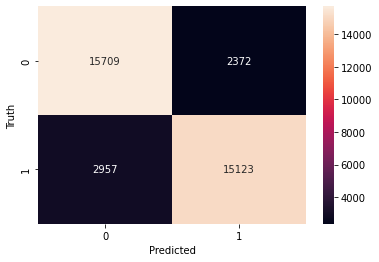

In [34]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [35]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

         0.0       0.84      0.87      0.85     18081
         1.0       0.86      0.84      0.85     18080

    accuracy                           0.85     36161
   macro avg       0.85      0.85      0.85     36161
weighted avg       0.85      0.85      0.85     36161



In [36]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 649ms/step


array([[0.17664273],
       [0.02832286],
       [0.05480204],
       [0.06121404],
       [0.23941357]], dtype=float32)

In [37]:
model.save('bert_model_with_neural_network')

INFO:tensorflow:Assets written to: bert_model_with_neural_network/assets


INFO:tensorflow:Assets written to: bert_model_with_neural_network/assets
